# Import packages

In [2]:
! cd $WORK

In [3]:

exp_odir = 'output/echam-6.3.05p2-wiso/pi/'
expid = ['pi_m_416_4.9',]
i = 0


# -----------------------------------------------------------------------------
# region import packages

# management
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/work/ollie/qigao001')
import sys  # print(sys.path)
sys.path.append('/work/ollie/qigao001')

# data analysis
import numpy as np
import xarray as xr
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
from scipy import stats
import xesmf as xe
import pandas as pd
from metpy.interpolate import cross_section
from statsmodels.stats import multitest
import pycircstat as circ
from metpy.calc import pressure_to_height_std
from metpy.units import units

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import cm
import cartopy.crs as ccrs
plt.rcParams['pcolor.shading'] = 'auto'
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', family='Times New Roman', size=10)
mpl.rcParams['axes.linewidth'] = 0.2
plt.rcParams.update({"mathtext.fontset": "stix"})
import matplotlib.animation as animation
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import AutoMinorLocator

# self defined
from a_basic_analysis.b_module.mapplot import (
    globe_plot,
    hemisphere_plot,
    quick_var_plot,
    mesh2plot,
    framework_plot1,
    remove_trailing_zero,
    remove_trailing_zero_pos,
)

from a_basic_analysis.b_module.basic_calculations import (
    mon_sea_ann,
)

from a_basic_analysis.b_module.namelist import (
    month,
    month_num,
    month_dec,
    month_dec_num,
    seasons,
    seasons_last_num,
    hours,
    months,
    month_days,
    zerok,
    panel_labels,
    seconds_per_d,
)

from a_basic_analysis.b_module.source_properties import (
    source_properties,
    calc_lon_diff,
)

from a_basic_analysis.b_module.statistics import (
    fdr_control_bh,
    check_normality_3d,
    check_equal_variance_3d,
    ttest_fdr_control,
)

from a_basic_analysis.b_module.component_plot import (
    cplot_ice_cores,
    cplot_lon180,
    cplot_wind_vectors,
    cplot_lon180_quiver,
    plt_mesh_pars,
)

# endregion
# -----------------------------------------------------------------------------



# Import data

In [4]:
# -----------------------------------------------------------------------------
# region import data

q_weighted_lat = {}
with open(
    exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.q_weighted_lat.pkl',
          'rb') as f:
    q_weighted_lat[expid[i]] = pickle.load(f)

uv_plev = {}
with open(
    exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.uv_plev.pkl',
    'rb') as f:
    uv_plev[expid[i]] = pickle.load(f)

q_plev = {}
with open(
    exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.q_plev.pkl',
    'rb') as f:
    q_plev[expid[i]] = pickle.load(f)

ocean_q_alltime = {}
with open(exp_odir + expid[i] + '/analysis/echam/' + expid[i] + '.ocean_q_alltime.pkl', 'rb') as f:
    ocean_q_alltime[expid[i]] = pickle.load(f)

lon = q_weighted_lat[expid[i]]['am'].lon
lat = q_weighted_lat[expid[i]]['am'].lat
lon_2d, lat_2d = np.meshgrid(lon, lat,)
plevs = q_weighted_lat[expid[i]]['am'].plev.sel(plev=slice(1e+5, 2e+4))

# endregion
# -----------------------------------------------------------------------------


# Plot am

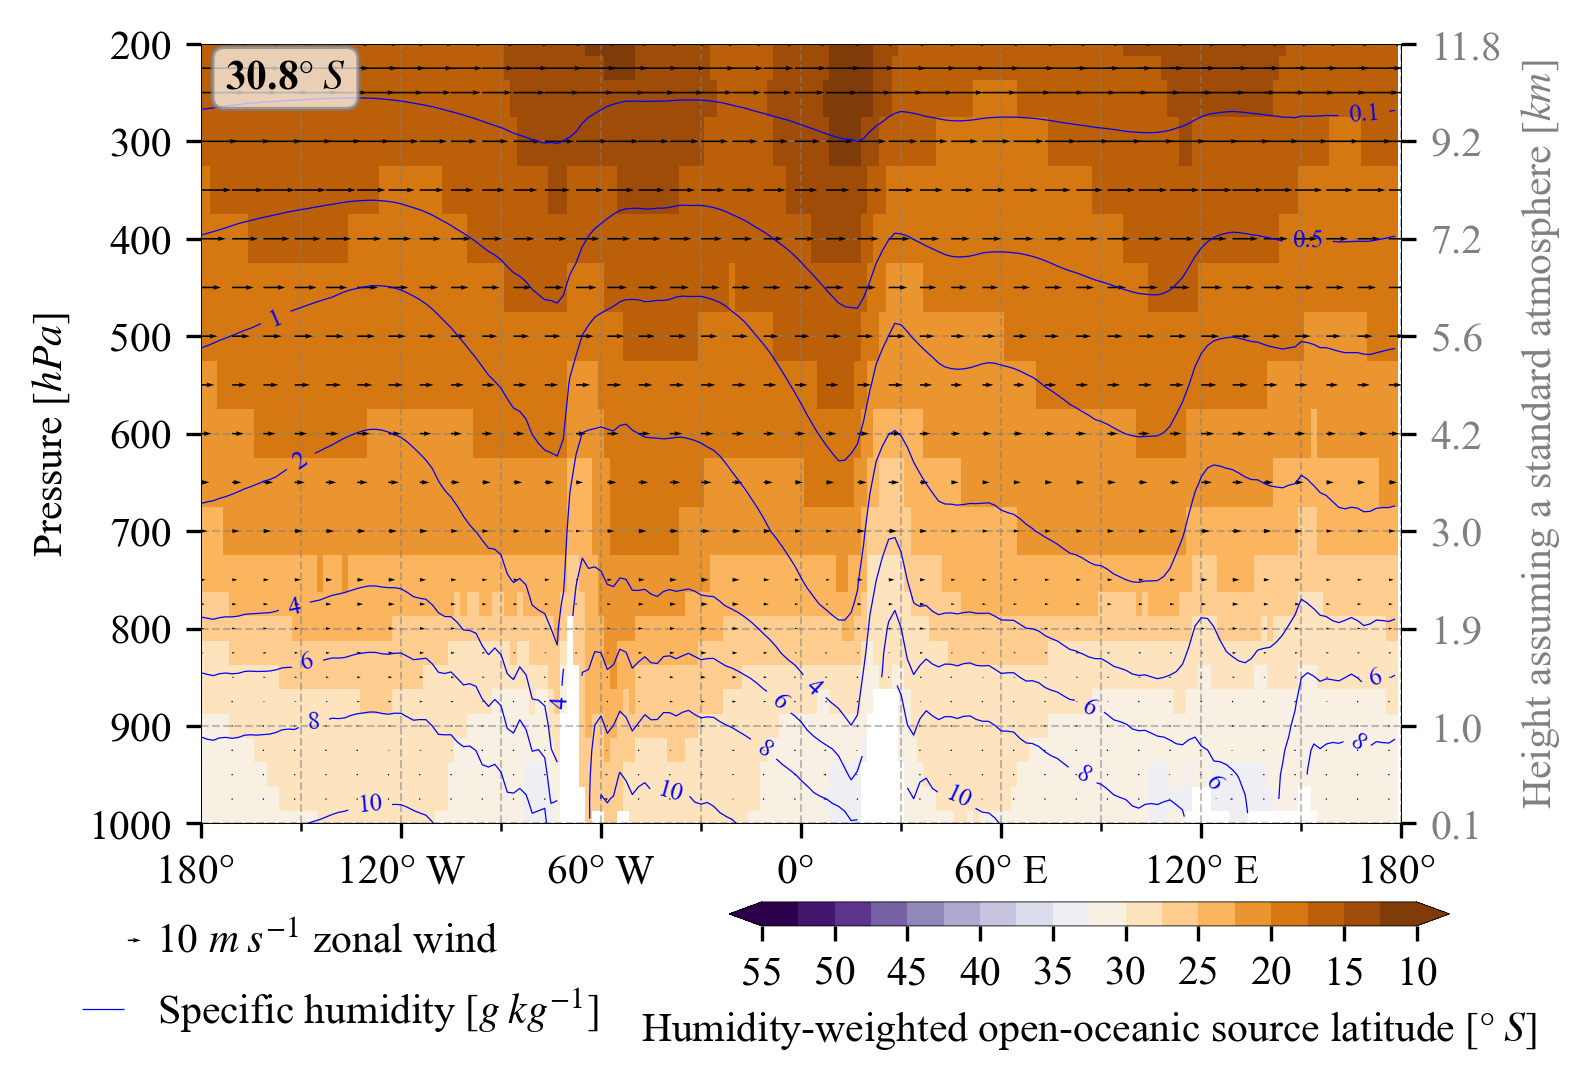

In [18]:
ilat = 64

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-55, cm_max=-10, cm_interval1=2.5, cm_interval2=5, cmap='PuOr',)

fig, ax = plt.subplots(1, 1, figsize=np.array([13.2, 8.8]) / 2.54)

plt_mesh = cplot_lon180(
    lon, plevs / 100, ax, pltnorm, pltcmp,
    q_weighted_lat[expid[i]]['am'].sel(
        lat = lat[ilat].values, plev=slice(1e+5, 2e+4)),)

plt_quiver = cplot_lon180_quiver(
    lon, plevs / 100, ax,
    plt_data = uv_plev[expid[i]]['u']['am'].sel(
        lat = uv_plev[expid[i]]['u']['am'].lat[ilat].values,
        plev=slice(1e+5, 2e+4)), color='k')

# x-axis
ax.set_xticks(np.arange(-180, 180 + 1e-4, 60))
ax.set_xlim(-180, 180)
ax.xaxis.set_major_formatter(LongitudeFormatter(degree_symbol='° '))

# y-axis
ax.invert_yaxis()
ax.set_ylim(1000, 200)
ax.set_ylabel('Pressure [$hPa$]')
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

# grid
ax.grid(True, lw=0.5, c='gray', alpha=0.5, linestyle='--', which='both',)

# 2nd y-axis
height = np.round(
    pressure_to_height_std(
        pressure=np.arange(1000, 200 - 1e-4, -100) * units('hPa')), 1,)
ax2 = ax.twinx()
ax2.invert_yaxis()
ax2.set_ylim(1000, 200)
ax2.set_yticklabels(np.flip(height.magnitude), c = 'gray')
ax2.set_ylabel('Height assuming a standard atmosphere [$km$]', c = 'gray')

# label lat cross-section
plt.text(
    0.02, 0.98, str(np.negative(np.round(lat[ilat].values, 1))) + '$°\;S$',
    transform=ax.transAxes, weight='bold',
    ha='left', va='top', rotation='horizontal',
    bbox=dict(boxstyle='round', fc='white', ec='gray', lw=1, alpha=0.7),)

def cplot_lon180_ctr(
    lon, y, ax,
    plt_data,
    q_intervals = np.array([0.1, 0.5, 1, 2, 4, 6, 8, 10]),
    colors='b', linewidths=0.3, clip_on=True,
    inline_spacing=10, fontsize=6
    ):
    '''
    #-------- Input
    
    #-------- Output
    
    '''
    
    import xarray as xr
    
    lon_180 = np.concatenate([
        lon[int(len(lon) / 2):] - 360, lon[:int(len(lon) / 2)], ])
    
    plt_data_180 = xr.concat([
        plt_data.sel(lon=slice(180, 360)),
        plt_data.sel(lon=slice(0, 180 - 1e-4))], dim='lon')
    
    plt_ctr = ax.contour(
        lon_180, y, plt_data_180,
        colors=colors, levels=q_intervals, linewidths=linewidths,
        clip_on=clip_on)
    
    ax_clabel = ax.clabel(
        plt_ctr, inline=1, colors=colors, fmt=remove_trailing_zero,
        levels=q_intervals, inline_spacing=inline_spacing, fontsize=fontsize,)
    
    return([plt_ctr, ax_clabel])

plt_ctr, ax_clabel = cplot_lon180_ctr(
    lon, plevs / 100, ax,
    plt_data = q_plev[expid[i]]['am'].sel(
        lat_2 = lat[ilat].values, plev=slice(1e+5, 2e+4)) * 1000
    )

# lon_180 = np.concatenate([
#     lon[int(len(lon) / 2):] - 360, lon[:int(len(lon) / 2)], ])

# plt_data = q_plev[expid[i]]['am'].sel(
#     lat_2 = lat[ilat].values, plev=slice(1e+5, 2e+4))
# plt_data_180 = xr.concat([
#     plt_data.sel(lon=slice(180, 360)),
#     plt_data.sel(lon=slice(0, 180 - 1e-4))], dim='lon') * 1000

# # q_intervals = np.concatenate((np.array([0.1, 0.5]), np.arange(1, 10 + 1e-5, 1)))
# q_intervals = np.array([0.1, 0.5, 1, 2, 4, 6, 8, 10])

# plt_ctr = ax.contour(
#     lon_180, plevs / 100, plt_data_180,
#     colors='b', levels=q_intervals, linewidths=0.2, clip_on=True)
# ax_clabel = ax.clabel(
#     plt_ctr, inline=1, colors='b', fmt=remove_trailing_zero,
#     levels=q_intervals, inline_spacing=10, fontsize=6)

# cbar
cbar = fig.colorbar(
    plt_mesh, ax=ax, aspect=30,
    orientation="horizontal", shrink=0.6, ticks=pltticks, extend='both',
    pad=0.02, fraction=0.25, anchor=(1.1, -0.6),)
cbar.ax.set_xticklabels(
    [remove_trailing_zero(x) for x in np.negative(pltticks)])
cbar.ax.set_xlabel('Humidity-weighted open-oceanic source latitude [$°\;S$]',)

# quiver key
ax.quiverkey(plt_quiver, X=-0.05, Y=-0.15, U=10,
             label='10 $m \; s^{-1}$ zonal wind',
             labelpos='E', labelsep=0.05,)

# contour label
h1, _ = plt_ctr.legend_elements()
ax_legend = ax.legend(
    [h1[0]], ['Specific humidity [$g \; kg^{-1}$]'],
    loc='lower left', frameon=False,
    bbox_to_anchor=(-0.13, -0.32),
    handlelength=1, columnspacing=1)

fig.subplots_adjust(left=0.12, right=0.89, bottom=0.23, top=0.98)

plt.show()

# Plot am zm

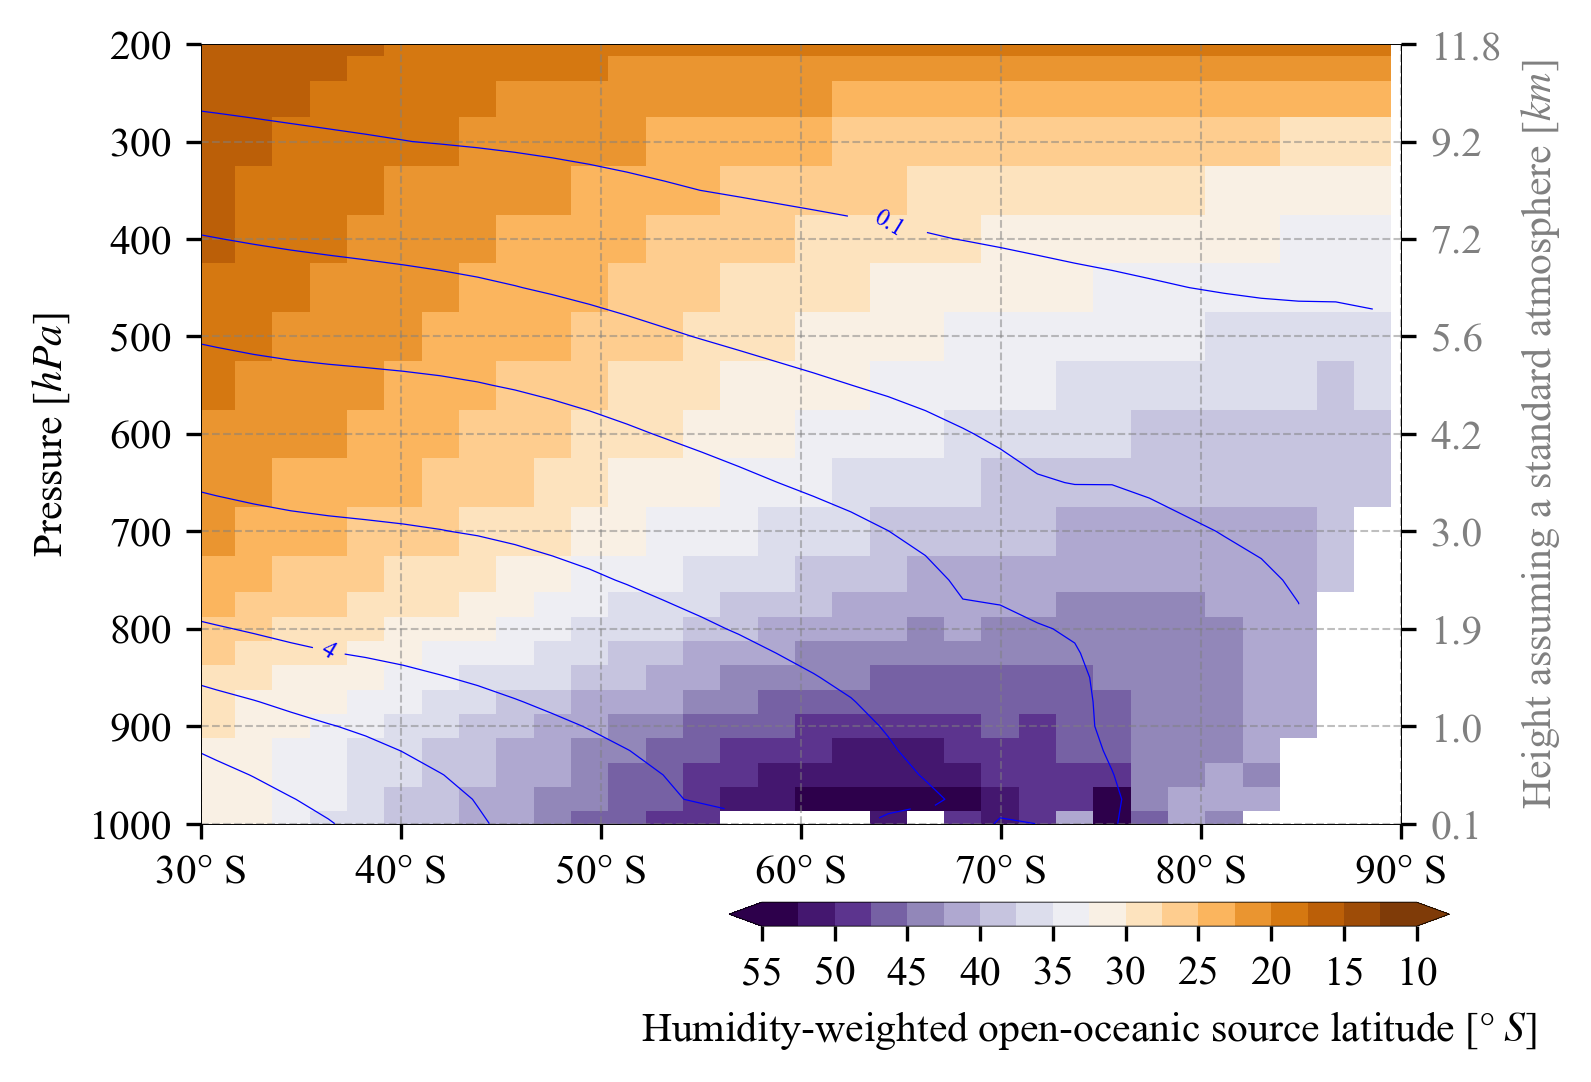

In [15]:

output_png = 'figures/6_awi/6.1_echam6/6.1.5_source_var_q/6.1.5.0_lat/6.1.5.0 ' + expid[i] + ' q_weighted_lat am zm.png'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-55, cm_max=-10, cm_interval1=2.5, cm_interval2=5, cmap='PuOr',)

fig, ax = plt.subplots(1, 1, figsize=np.array([13.2, 8.8]) / 2.54)

plt_mesh = ax.pcolormesh(
    lat, plevs / 100,
    q_weighted_lat[expid[i]]['am'].weighted(
        ocean_q_alltime[expid[i]]['am'].sel(var_names='lat').fillna(0)
        ).mean(dim='lon').sel(plev=slice(1e+5, 2e+4)),
    norm=pltnorm, cmap=pltcmp,
)

# q contours
q_intervals = np.array([0.1, 0.5, 1, 2, 4, 6, 8, 10])
plt_ctr = ax.contour(
        lat, plevs / 100,
        q_plev[expid[i]]['am'].mean(dim='lon').sel(
            plev=slice(1e+5, 2e+4)) * 1000,
        colors='b', levels=q_intervals, linewidths=0.3,
        clip_on=True, zorder=2)
ax_clabel = ax.clabel(
    plt_ctr, inline=1, colors='b', fmt=remove_trailing_zero,
    levels=q_intervals, inline_spacing=0, fontsize=6,)

# x-axis
ax.set_xticks(np.arange(-30, -90 - 1e-4, -10))
ax.set_xlim(-30, -90)
ax.xaxis.set_major_formatter(LatitudeFormatter(degree_symbol='° '))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

# y-axis
ax.invert_yaxis()
ax.set_ylim(1000, 200)
ax.set_ylabel('Pressure [$hPa$]')

# grid
ax.grid(True, lw=0.5, c='gray', alpha=0.5, linestyle='--', which='both',)

# 2nd y-axis
height = np.round(
    pressure_to_height_std(
        pressure=np.arange(1000, 200 - 1e-4, -100) * units('hPa')), 1,)
ax2 = ax.twinx()
ax2.invert_yaxis()
ax2.set_ylim(1000, 200)
ax2.set_yticklabels(np.flip(height.magnitude), c = 'gray')
ax2.set_ylabel('Height assuming a standard atmosphere [$km$]', c = 'gray')

# cbar
cbar = fig.colorbar(
    plt_mesh, ax=ax, aspect=30,
    orientation="horizontal", shrink=0.6, ticks=pltticks, extend='both',
    pad=0.02, fraction=0.25, anchor=(1.1, -0.6),)
cbar.ax.set_xticklabels(
    [remove_trailing_zero(x) for x in np.negative(pltticks)])
cbar.ax.set_xlabel('Humidity-weighted open-oceanic source latitude [$°\;S$]',)

fig.subplots_adjust(left=0.12, right=0.89, bottom=0.23, top=0.98)

plt.show()